In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=0)

In [14]:
'''
second performance test
'''
%time
import sys
sys.path.append('..')
%matplotlib inline
# you might need this:
#import matplotlib
#matplotlib.use('Agg')

from eden.converter.graph.gspan import gspan_to_eden
from graphlearn.graphlearn import GraphLearnSampler
from graphlearn.graphlearn_cipml.graphlearn_cipml import GraphLearnSamplerCipML
import itertools
from eden.graph import Vectorizer
import matplotlib.pyplot as plt
import numpy as np

from eden.util import fit_estimator,fit , random_bipartition_iter,estimate
import random
from eden.util import selection_iterator as picker
from sklearn.linear_model import SGDClassifier

vectorizer = Vectorizer( complexity=2 )
#2401 positives and 1936 negatives
NUMPOS=2401
NUMNEG=1936

######################## testing ##############################
from eden.util import iterator_size 
from time import time
def train_estimator_and_evaluate_testsets(pos_original,neg_original,pos_augmented,neg_augmented,pos_test,neg_test):
    # create graph sets...orig augmented and sampled
    pos_orig,pos_orig_ = itertools.tee(pos_original)
    neg_orig,neg_orig_ = itertools.tee(neg_original)
    
    pos_augmented , pos_sampled = itertools.tee(pos_augmented)
    neg_augmented , neg_sampled = itertools.tee(neg_augmented)
    
    pos_augmented = itertools.chain(pos_augmented,pos_orig_)
    neg_augmented = itertools.chain(neg_augmented,neg_orig_)

    predictive_performances=[]
    for desc,pos_train,neg_train in [('original',pos_orig, neg_orig),( 'original+sample',pos_augmented, neg_augmented),('sample',pos_sampled,neg_sampled)]:
        pos_train,pos_train_=itertools.tee(pos_train)
        neg_train,neg_train_=itertools.tee(neg_train)
        pos_size=sum(1 for x in pos_train_)
        neg_size=sum(1 for x in neg_train_)
        start=time()
        print "-"*80
        print 'working on %s'%(desc)
        print 'training set sizes: #pos: %d #neg: %d'%(pos_size, neg_size)
        pos_test,pos_test_=itertools.tee(pos_test)
        neg_test,neg_test_=itertools.tee(neg_test)
        local_estimator = fit( pos_train,neg_train,vectorizer,n_jobs=-1, n_iter_search=1 )
        apr, roc = estimate(pos_test_,neg_test_,local_estimator,vectorizer)
        predictive_performances.append(roc)
        print 'elapsed: %.1f sec'%(time()-start)
    return predictive_performances


def sample(graphs):
    sampler = GraphLearnSamplerCipML(radius_list=[0,1,2],thickness_list=[1,2])
    graphs, graphs_ = itertools.tee(graphs)
    sampler.fit(graphs, n_jobs=1, core_interface_pair_remove_threshold=3, interface_remove_threshold=3)
    n_steps=10
    sampling_factor=2 #how many samples per seed
    
    #sampling_interval=np.ceil([n_steps/sampling_factor])
    graphs = sampler.sample(graphs_,
                        same_radius=False,
                        same_core_size=True,
                        select_cip_max_tries=200,
                        batch_size=30,
                        n_steps=n_steps,
                        n_jobs=1,
                        accept_annealing_factor=1.2,
                        probabilistic_core_choice=True,
                        generatormode=False)
    for g in graphs:
            yield g
            
def sample_OLD(graphs):
    sampler = GraphLearnSampler(radius_list=[0,1,2],thickness_list=[1,2])
    graphs, graphs_ = itertools.tee(graphs)
    sampler.fit(graphs, n_jobs=1, core_interface_pair_remove_threshold=3, interface_remove_threshold=3)
    n_steps=10
    sampling_factor=2 #how many samples per seed
    
    #sampling_interval=np.ceil([n_steps/sampling_factor])
    graphs = sampler.sample(graphs_,
                        same_radius=False,
                        same_core_size=True,
                        select_cip_max_tries=200,
                        batch_size=30,
                        n_steps=n_steps,
                        n_jobs=1,
                        accept_annealing_factor=1.2,
                        probabilistic_core_choice=True,
                        generatormode=False)
    for g in graphs:
            yield g

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


In [15]:
%time
from time import time
from itertools import tee
import os
os.nice(19)
# initializing 
graphs_pos= gspan_to_eden('bursi.pos.gspan')
graphs_neg= gspan_to_eden('bursi.neg.gspan')
#take 70% train 30% test
pos_train_global,pos_test_global = random_bipartition_iter(graphs_pos,0.7)
neg_train_global,neg_test_global = random_bipartition_iter(graphs_neg,0.7)



percentages=[ .1, .2, .3, .4]

r1=[]
r2=[]
r3=[]
for percentage in percentages:
    
    
    originals=[]
    originals_samples=[]
    samples=[]
    for asd in range(5):
        pos_train_global,pos_train_global_ = tee(pos_train_global)
        neg_train_global,neg_train_global_ = tee(neg_train_global)
        pos_test_global,pos_test_global_ = tee(pos_test_global)
        neg_test_global,neg_test_global_ = tee(neg_test_global)

        # use shuffled list to create test and sample set
        pos,pos_reminder = random_bipartition_iter(pos_train_global_,percentage)
        pos,pos_ = tee(pos)
        neg,neg_reminder = random_bipartition_iter(neg_train_global_,percentage)
        neg,neg_ = tee(neg)

        #sample independently from the 2 classes
        sampled_pos = sample(pos)
        sampled_neg = sample(neg)

        #evaluate the predictive performance on held out test set
        start=time()
        print "="*80
        print "training percentage:"+str(percentage)
        perf_orig, perf_orig_samp, perf_samp = train_estimator_and_evaluate_testsets(pos_,
                                                                                     neg_,
                                                                                     sampled_pos, 
                                                                                     sampled_neg, 
                                                                                     pos_test_global_,
                                                                                     neg_test_global_)
        originals.append(perf_orig)
        originals_samples.append(perf_orig_samp)
        samples.append(perf_samp)
    
    r1.append(originals)
    r2.append(originals_samples)
    r3.append(samples)
    
    print 'Time elapsed for perc: %.2f : %.1f sec'%(percentage,(time()-start))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs
training percentage:0.1
--------------------------------------------------------------------------------
working on original
training set sizes: #pos: 168 #neg: 135
elapsed: 10.4 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 336 #neg: 270
elapsed: 16.1 sec
--------------------------------------------------------------------------------
working on sample
training set sizes: #pos: 168 #neg: 135
elapsed: 11.5 sec
training percentage:0.1
--------------------------------------------------------------------------------
working on original
training set sizes: #pos: 168 #neg: 135
elapsed: 12.2 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 336 #neg: 270
elapsed: 17.0 sec
--------------------------------------------------------------------------------


/home/diegocerdan/.local/lib/python2.7/site-packages/sklearn/calibration.py:398: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/diegocerdan/.local/lib/python2.7/site-packages/sklearn/calibration.py:408: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/diegocerdan/.local/lib/python2.7/site-packages/sklearn/calibration.py:410: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)


elapsed: 25.7 sec
--------------------------------------------------------------------------------
working on sample
training set sizes: #pos: 336 #neg: 271
elapsed: 16.4 sec
training percentage:0.2
--------------------------------------------------------------------------------
working on original
training set sizes: #pos: 336 #neg: 271
elapsed: 17.9 sec
('FITTED ', 1504)
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 672 #neg: 542
elapsed: 27.1 sec
--------------------------------------------------------------------------------
working on sample
training set sizes: #pos: 336 #neg: 271
elapsed: 16.8 sec
training percentage:0.2
--------------------------------------------------------------------------------
working on original
training set sizes: #pos: 336 #neg: 271
elapsed: 18.1 sec
('FITTED ', 1502)
--------------------------------------------------------------------------------
working on original

In [ ]:
r1_OLD=[]
r2_OLD=[]
r3_OLD=[]
for percentage in percentages:
    
    
    originals_OLD=[]
    originals_samples_OLD=[]
    samples_OLD=[]
    for asd in range(5):
        pos_train_global,pos_train_global_ = tee(pos_train_global)
        neg_train_global,neg_train_global_ = tee(neg_train_global)
        pos_test_global,pos_test_global_ = tee(pos_test_global)
        neg_test_global,neg_test_global_ = tee(neg_test_global)

        # use shuffled list to create test and sample set
        pos,pos_reminder = random_bipartition_iter(pos_train_global_,percentage)
        pos,pos_ = tee(pos)
        neg,neg_reminder = random_bipartition_iter(neg_train_global_,percentage)
        neg,neg_ = tee(neg)

        #sample independently from the 2 classes
        sampled_pos = sample(pos)
        sampled_neg = sample(neg)

        #evaluate the predictive performance on held out test set
        start=time()
        print "="*80
        print "training percentage:"+str(percentage)
        perf_orig, perf_orig_samp, perf_samp = train_estimator_and_evaluate_testsets(pos_,
                                                                                     neg_,
                                                                                     sampled_pos, 
                                                                                     sampled_neg, 
                                                                                     pos_test_global_,
                                                                                     neg_test_global_)
        originals_OLD.append(perf_orig)
        originals_samples_OLD.append(perf_orig_samp)
        samples_OLD.append(perf_samp)
    
    r1_OLD.append(originals_OLD)
    r2_OLD.append(originals_samples_OLD)
    r3_OLD.append(samples_OLD)
    
    print 'Time elapsed for perc: %.2f : %.1f sec'%(percentage,(time()-start))

training percentage:0.1
--------------------------------------------------------------------------------
working on original
training set sizes: #pos: 168 #neg: 135


[[0.83516762452107185, 0.82425047892720393, 0.82828304597701086, 0.83148706896551694, 0.83101772030651233], [0.86459291187739606, 0.86786877394636275, 0.86933908045977071, 0.85987308429118892, 0.86504070881226125], [0.87105363984674211, 0.86974856321838778, 0.87262691570881445, 0.86973180076628143, 0.87086685823754895], [0.87214559386973223, 0.87171455938697229, 0.87531609195402316, 0.87613505747126497, 0.87482998084291264]] [[0.83490421455938635, 0.82598180076628325, 0.82893678160919393, 0.82992576628352555, 0.82848419540230012], [0.8665062260536418, 0.86454741379310318, 0.86608716475095704, 0.86204501915708731, 0.86685823754789026], [0.87172892720306472, 0.87029454022988562, 0.87188218390804317, 0.87205699233716349, 0.86867576628352428], [0.8745043103448269, 0.87396312260536357, 0.87579741379310483, 0.87685105363984472, 0.87026340996168849]] [[0.59309746168582356, 0.60053160919540205, 0.55426364942528783, 0.59186781609195416, 0.61762452107279653], [0.60133500957854469, 0.568987068965

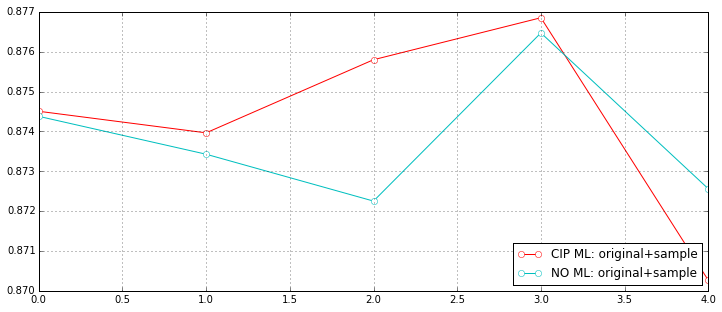

In [17]:
# draw 

# all the info is there to draw THAT
#print r1,r2,r3

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.grid()

plt.plot(originals_samples, color='r', marker='o', markersize=6, markeredgecolor='r', markerfacecolor='w', label='CIP ML: original+sample')

plt.plot(originals_samples_OLD, color='c', marker='o', markersize=6, markeredgecolor='c', markerfacecolor='w', label='NO ML: original+sample')

plt.legend(loc='lower right')
plt.savefig('plot_predictive_performance_of_samples.pdf')

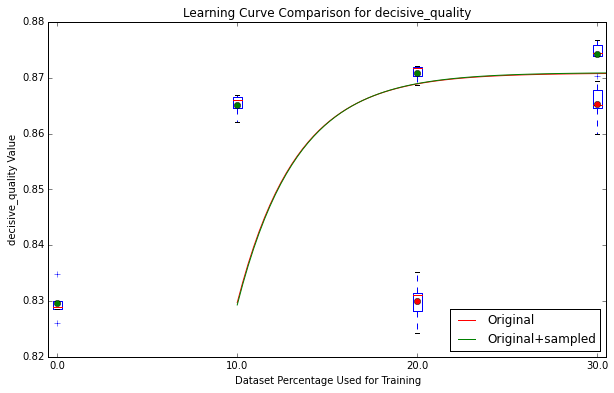

In [22]:
from graphlearn.utils.draw import draw_learning_curve
#draw_learning_curve(data_A=r1,data_B=r2,x=percentages,measure='decisive_quality')
draw_learning_curve(data_A=r1,data_B=r2,x=percentages,measure='decisive_quality')

In [19]:
# looks weired oOo